# ADD A CONTENTS OR INDEX TO THE BLOG
for each subheading i think

---

This is the second post on the road to StyleGAN2. In this post we implement the StyleGAN and in the third and final post we will implement StyleGAN2.

You can find the <b>StyleGAN</b> paper we will be following <a href="https://arxiv.org/pdf/1812.04948">here</a>. Note, if I refer to the "the authors" I am referring to Karras et al, they are the authors of the StyleGAN paper.

This post will be a lot shorter than my last post, on the <a href="https://ym2132.github.io/Progressive_GAN">Progressive Growing GAN (PGGAN)</a>, because the StyleGAN reuses a lot of the techniques from the PGGAN. As such, I strongly suggest you read the PGGAN post if you haven't before proceeding (so much is reused from the PGGAN, understanding it is a pre-requisite to understanding the StyleGAN).

We make use of the CelebA-HQ 256 dataset again, it can be found at: <a href="https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256">https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256</a>

---

Expand this block to show code for imports and some helper functions :)

In [26]:
#| code-fold: true

# Before we continue lets set our inputs and configure the device for our model code
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision import datasets, transforms, utils

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime
import os
from math import sqrt
import random

# We can make use of a GPU if you have one on your computer. This works for Nvidia and M series GPU's
if torch.backends.mps.is_available():
    device = torch.device("mps")
    # These 2 lines assign some data on the memory of the device and output it. The output confirms
    # if we have set the intended device
    x = torch.ones(1, device=device)
    print (x)
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = ("cpu")
    x = torch.ones(1, device=device)
    print (x)
    
# I also define a function we use to examine the outputs of the Generator
def show_images(images, num_images=16, figsize=(10,10)):
    # Ensure the input is on CPU
    images = images.cpu().detach()
    
    # Normalize images from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    
    # Clamp values to [0, 1] range
    images = torch.clamp(images, 0, 1)
    
    # Make a grid of images
    grid = torchvision.utils.make_grid(images[:num_images], nrow=4)
    
    # Convert to numpy and transpose
    grid = grid.numpy().transpose((1, 2, 0))
    
    # Display the grid
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

tensor([1.], device='mps:0')


<h2> StyleGAN - Building on the Progressive Growing GAN</h2>

The implementation of the StyleGAN makes a few major changes to the Generator (G) architecture, but the underlying structure follows the Progressive Growing GAN (PGGAN) paper. The Discriminator model remains unchanged from the PGGAN. Through modifying the G setup, StyleGAN achieves better image generation than PGGAN. Also, this paper covers some very interesting topics which shed light on the inner workings of GANs.

The trouble with with the PGGAN and other GANs is the lack of ways to modify the generator output. One of the key ideas of modifying the G is to expose new ways to control image generation. Previously, the only input to the model was the input latent vector[<sup>6</sup>](#6), in the StyleGAN we switch this up. Rather than starting from a latent vector $\textbf{z}$, we start from a learned constant. But, fret not we still have a place for $\textbf{z}$, it is used in a mapping network (don't worry we will explore all of this in depth later) to create an intermediate learned latent vector $\textbf{w}$. $\textbf{w}$ is used in the Adapative Instance layers of the network and is one way to control generation in the StyleGAN. The second way comes through random noise injection, which takes place after each convolutional layer.

The "Style" part of StyleGAN refers to style transfer. The goal of style transfer is to render the same content of an image in different styles[<sup>1</sup>](#1), take a look at Figure 1 for an illustration of how to think about this.

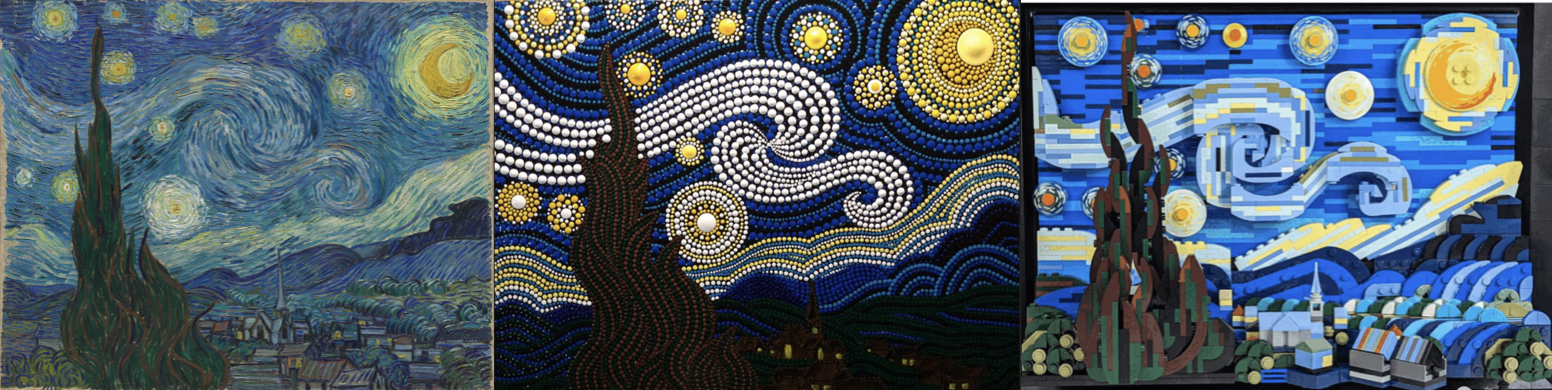 

Style transfer is typically concerned with transferring the style of one image to another, with the style coming from an existing image. The authors choose to depart from this and instead of an image we use a seperate network to define the "styles", in this sense they are not "styles" (hence the "") as defined in the literature but they are used in the same manner hence why the name is the same. The style's are used to control the Adaptive Instance Normalisation (AdaIN).

<h2>The Path to Implementation - A Roadmap</h2>

In Figure 2 we see the architecture of the G model in the StyleGAN. The numbers denote the order in which I will cover each part (boxes denote each seperate part) of the network. Explained on their own the parts can get a bit confusing, so keep this image in mind as you read on and the whole thing will make a lot more sense.

Before we implement the whole network I want to discuss the following pieces of the G network individually:

    1 - The Mapping network
    2 - The AdaIN layer
    3 - Addition of random noise to images
    4 - Style Mixing (not labelled here)
    5 - Learned Constant (Const 4x4x512 in the image, ours will be 4x4x256)

We will then wrap this all up in a neat package and implement the full G network.

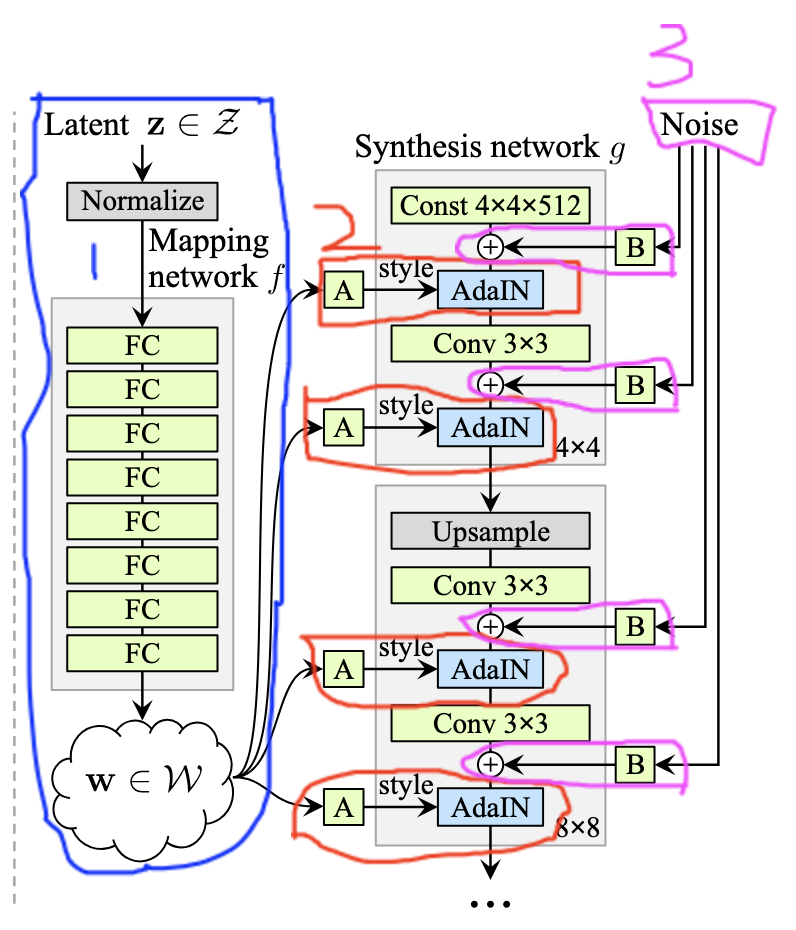

<h3>The Old Stuff</h3>

By old stuff I mean things we implemented in the PGGAN post but which we will reuse here. To name they are the Equal LR layers, Pixel Norm, MiniBatch standard deviation, WGAN-GP loss (this will be in the training loop), EMA and the entire Discriminator network. I will include the code here and refer you to the first post in this series for further details.

Expand the following code block to see the old stuff :)

In [36]:
#| code-fold: true

class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)

class MiniBatchStdDev(nn.Module):
    def __init__(self, group_size=4):
        super().__init__()
        self.group_size = group_size
    
    def forward(self, x):
        N, C, H, W = x.shape 
        G = min(self.group_size, N) 
        
        y = x.view(G, -1, C, H, W)
        
        y = y - torch.mean(y, dim=0, keepdim=True)
        y = torch.mean(torch.square(y), dim=0)
        y = torch.sqrt(y + 1e-8)
        
        y = torch.mean(y, dim=[1,2,3], keepdim=True)
        
        y = y.repeat(G, 1, H, W)
        
        return torch.cat([x,y], dim=1)    

def EMA(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)    

class EqualLR:
    def __init__(self, name):
        self.name = name
    
    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig') 
        fan_in = weight.data.size(1) * weight.data[0][0].numel()

        return weight * sqrt(2 / (fan_in))

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)
        
        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)


def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)

    return module

class EqualLRConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()

        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)


class EqualLRConvTranspose2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.ConvTranspose2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()

        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)

class EqualLRLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = equal_lr(linear)

    def forward(self, input):
        return self.linear(input)
    
class D_ConvBlock(nn.Module):
    def __init__(
        self,
        in_c,
        out_c,
        ksize1, 
        padding, 
        ksize2=None, 
        padding2=None,
        stride=None,   
        mbatch=None,
    ):
        super().__init__()
        
        layers_list = []
        
        if ksize2 is None:
            ksize2 = ksize1
        if padding2 is None:
            padding2 = padding
        
        if mbatch:
            layers_list.extend([
                MiniBatchStdDev(),
            ])
            
        layers_list.extend([
            EqualLRConv2d(in_c, out_c, ksize1, padding=padding),
            nn.LeakyReLU(0.2),
            EqualLRConv2d(out_c, out_c, ksize2, padding=padding2),
            nn.LeakyReLU(0.2),
        ])
        
        self.layers = nn.ModuleList(layers_list)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, out_c=256):
        super().__init__()
        
        self.blocks = nn.ModuleList([
            D_ConvBlock(out_c//4, out_c//4, 3, 1),
            D_ConvBlock(out_c//4, out_c//2, 3, 1),
            D_ConvBlock(out_c//2, out_c, 3, 1),
            D_ConvBlock(out_c, out_c, 3, 1),
            D_ConvBlock(out_c, out_c, 3, 1),
            D_ConvBlock(out_c, out_c, 3, 1), 
            D_ConvBlock(out_c+1, out_c, 3, 1, 4, 0, mbatch=True),
        ])
        
        self.from_rgb = nn.ModuleList([
            EqualLRConv2d(3, out_c//4, 1),
            EqualLRConv2d(3, out_c//4, 1),
            EqualLRConv2d(3, out_c//2, 1),
            EqualLRConv2d(3, out_c, 1),
            EqualLRConv2d(3, out_c, 1),
            EqualLRConv2d(3, out_c, 1),
            EqualLRConv2d(3, out_c, 1),
        ])
        self.num_layers = len(self.blocks)
        
        self.linear = EqualLRLinear(out_c, 1)
    
    def forward(self, x, layer_num, alpha):
        for i in reversed(range(layer_num)):
            idx = self.num_layers - i - 1
            if i+1 == layer_num:
                out = self.from_rgb[idx](x)
            out = self.blocks[idx](out)
            if i > 0:
                out = F.interpolate(out, scale_factor=0.5, mode='bilinear')
                
                if i+1 == layer_num and 0 <= alpha < 1:
                    skip = F.interpolate(x, scale_factor=0.5, mode='bilinear')
                    skip = self.from_rgb[idx + 1](skip)
                    out = ((1 - alpha) * skip) + (alpha * out)
        
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

d = Discriminator().to(device)

<h3>The Mapping Network</h3>

From Figure 2 in the blue box (1) we see the Mapping network is a simple network consisting of only fully connected (linear) layers. It takes as input a latent vector $\textbf{z}$, usually $\textbf{z}$ is fed directly to the G model however in StyleGAN it is not, actually look at Figure 2, you see G actually has no input instead it starts from a learned constant (we'll come back to this). Anyways, the output is a learned latent vector $\textbf{w}$. The dimensions of both $\textbf{z}$ and $\textbf{w}$ are 256, the paper has them at 512 but as our model has a smaller capacity (we only generate up to 256x256 images, I did the same for my PGGAN implementation), whereas the paper outputs 1024x1024 images). We see then this $\textbf{w}$ is used in the AdaIN layer, and it is the style part of our network.

I'm not sure exactly why this Mapping network is used, but here's what I can decipher from the paper. The idea is that using a Mapping network allows $\textbf{w}$ to be disentangled, whereas $\textbf{z}$ is not. What does disentangled mean? To my understanding, the goal of disentanglement is a latent vector in which each linear subspace represents a different factor of variation[<sup>2</sup>](#2). Now, $\textbf{z}$ does not have this property but $\textbf{w}$ does, this arises from the fact that $\textbf{w}$ is learnt thus giving it more freedom. Also, the setup of the GAN forces $\textbf{w}$ to become more disentangled through training. In theory it is easier for G to generate realistic images from a more disentangled representation, so training should push mapping network to creating a more disentangled $\textbf{w}$. 

The paper does provide some metrics to measure the amount of disentanglement but I skip over it. Now, then let's get into implement the Mapping network!

In [11]:
class MappingNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # We normalise the input with PixelNorm
        self.norm = PixelNorm()
        
        # I set output to 256 to match the shortened G case
        # As we just want to pass the input through the whole network, I use a PyTorch Sequential
        # it allows us to pass our input through multiple layers with a single line in the forward method.
        self.layers = nn.Sequential(
            # I set the dimensionality of each layer to be the same. Perhaps you could change the hidden layer dimensions
            # and see what happens.
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        # Normalise input latent
        x = self.norm(x)

        # Using the Sequential pass the normalised input through the network
        out = self.layers(x)
        
        return out

Thats the mapping network done, it's simple enough by itself. Time for the Adaptive Instance Normalisation!

<h3>Adaptive Instance Normalisation (AdaIN)</h3>

The goal of style transfer is to find a way to transfer the style of an image to another without changing the content. A useful tool to achieve this is the Adaptive Instance Normalisation (AdaIN) layer[<sup>3</sup>](#3). AdaIN is another of the major changes in the G model, replacing PixelNorm and allowing us to adjust the style of our generated images at different points in the model[<sup>4</sup>](#4). You see in Figure 2, that the output of the mapping network is passed to all the AdaIN layers. But, the $\textbf{w}$ is first passed through a learned affine transform $\textbf{A}$. This transform is what produces the style in our network for use in the AdaIN.

<h4>Style Transfer - A Quick Detour</h4>

Let us embark on a discussion of style transfer and the origins of AdaIN before we implement it. The style of an image can be found from it's feature statistics, namely the mean and variance of an image. The idea is to use the mean and variance of the image whose style we want and make our other images match it. This can be done with different normalisation techniques[<sup>5</sup>](#5), we call this Style Normalisation (from the paper I just linked to). Instance Normalisation can be used to perform style normalisation, which is normalising an image to have the style of another (making the mean and variance of that image match the style's mean and variance). However, IN can only normalise images to one single style, whereas AdaIN can be adapted to many different styles through the extra input $\textbf{y}$ seen in Figure 3. 

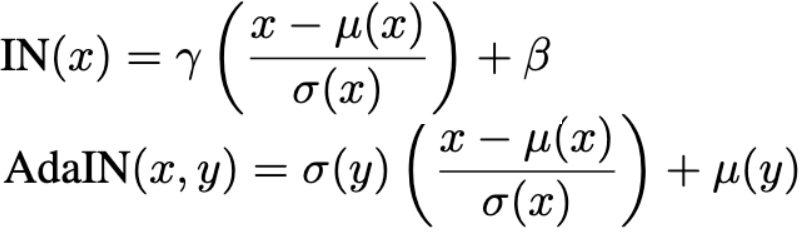

Take a look at the formula for AdaIN vs IN in Figure 3. They are very similar, except AdaIN takes another input $\textbf{y}$, this is the style. Consider IN, first the part in the brackets normalises the input $\textbf{x}$ and then it is adapted to have the feature statistics denoted by $\gamma$ and $\beta$. Whereas, in AdaIN the normalised $\textbf{x}$ is adapted to have the feature statistics determined by the style $\textbf{y}$. If you look closely at both formulas the operations outside the brakcets reverse the normalisation but with a new mean and std dev. 

So what AdaIN does is very simple, it aligns the input $\textbf{x}$ to have the same mean and std dev of the style input. Typically, the style input is not a learnable parameter, but in the StyleGAN it is. Take a look at Figure 4 for the AdaIN we use (it's almost identical, can you spot the difference?). 

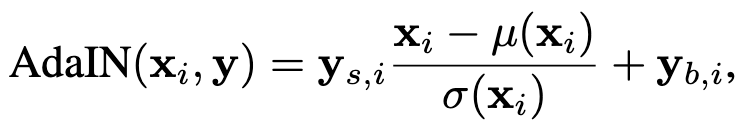

The AdaIN in Figure 4 has the same input $\textbf{y}$, but there are two aspects of it in the equation. $\textbf{y}_s$ is the style and $\textbf{y}_b$ is the bias. Both of these come from the learned affine transformation $\textbf{A}$ which is peformed on $\textbf{w}$ before it is passed to the AdaIN layers. Let's discuss the goal of $\textbf{A}$ and the mapping network. They together provide a way to draw samples for each style from a learned distribution $\textbf{W}$, we sample many different styles at each AdaIN in the network. The G uses these sampled styles to generate novel images. Furthermore it happens that (as stated by Karras) the styles are localises throughout the network, meaning at each point the style corresponds to something different in the images. The localisation occurs due to the formulation of AdaIN, let's think about this before moving on. The middle part of Figure 4, normalises the input x the effect of this is setting the mean to 0 and the std dev to 1 and thereafter the $\textbf{y}_s$ and $\textbf{y}_b$ are applied, this is the root of localisation. By normalising the input image first we essentially reset the statistical properties, removing the influence of previous AdaIN operations and only the current style effects are applied. In other words, each AdaIN only controls one convolution operation before being overwritten by the next AdaIN.
 
Now what exactly is a learned affine transformation? Well, in a neural network setting it often refers to a linear forward pass (essentially we multiply our input by a weight and add a bias, to make it a learned operation but we keep the dimensionality the same), so we implement it as a pass through a linear layer.

Now you know how AdaIN works, let's implement it!

In [27]:
# We define AdaIN as a PyTorch module
class AdaIN(nn.Module):
    # As input we take the number of dimensions we have in our latent space, the number  and the current number of dimensions
    # the current number will change based on the layer. Remember as we grow our G we decrease the number of channels with it starting
    # at 256 and ending at 64
    def __init__(self, latent_dim, current_c):
        super().__init__()

        # Our map layer is a simple Linear layer, we make use of the EqLR linear layer we implemented in the previous post
        self.map_layer = EqualLRLinear(latent_dim, current_c*2)  # Style is 2x current dim, this is stated in the paper
        # Look ahead for why it is 2x current dim.
        # IN constitutes the middle part of Figure 4 (without the y's), the default for InstanceNorm2d is affine=False (gamma and beta
        # are not used when affine=False)
        self.IN = nn.InstanceNorm2d(current_c)

    # As input to our forward pass we have w - the output of the mapping network 
    # and the image (the object being passed through the network)
    def forward(self, w, image):
        # To get out style we pass w through the affine transformation
        style = self.map_layer(w)
        # We need to create y_style and y_bias from the style output. To do this we use the chunk method from PyTorch
        # chunk splits the tensor in 2 down the middle, so we will end up with y_s and y_b having half the number of channels that style 
        # has, this is why we do current_c*2 in the map_layer. 
        y_s, y_b = style.chunk(2, dim=1)
        
        # Reshape y_s and y_b to match image's dimensions, currently the dims of y_s and y_b are (N, C) and image is (N, C, H, W)
        # after the unsqueezes the dims of y_s and y_b will be (N, C, 1, 1)
        y_s = y_s.unsqueeze(2).unsqueeze(3)
        y_b = y_b.unsqueeze(2).unsqueeze(3)

        # Implement the full formula
        return (y_s * self.IN(image)) + y_b

***
Expand the following code block to get some insight into the forward method of AdaIN

In [28]:
#| code-fold: true

w = torch.randn(1, 256)
map_layer = nn.Linear(256, 512)
style = map_layer(w)
y_s, y_b = style.chunk(2, dim=1)
print(y_s.shape, y_b.shape)
y_s = y_s.unsqueeze(2).unsqueeze(3)
y_b = y_b.unsqueeze(2).unsqueeze(3)
print(y_s.shape, y_b.shape)

torch.Size([1, 256]) torch.Size([1, 256])
torch.Size([1, 256, 1, 1]) torch.Size([1, 256, 1, 1])


The use of InstancNorm2d had me stumped for a while, I wanted to prove by setting affine=False it's not a learned operation. Expand the code block below to see how we can use PyTorch to check if we have correctly turned off the learning.

In [29]:
#| code-fold: true

# We create a random input with 4 channels
x = torch.randn(1, 4, 10, 10) 

# Define two different InstanceNorm2d operation. One with learning on and the other off
in_affine_on = nn.InstanceNorm2d(4, affine=True)
in_affine_off = nn.InstanceNorm2d(4, affine=False)

print("InstanceNorm2d with affine=True:")
# Access the params
for name, param in in_affine_on.named_parameters():
    print(f"{name}: shape {param.shape}, requires_grad {param.requires_grad}")
print("\nInstanceNorm2d with affine=False:")
for name, param in in_affine_off.named_parameters():
    print(f"{name}: shape {param.shape}, requires_grad {param.requires_grad}")

# You see the above code prints nothing for in_affine_off let's explor it more here
# We see that there are 0 params, which means nothing to learn and hence learned is off correctly
print(f"\nNumber of parameters (affine=True): {sum(p.numel() for p in in_affine_on.parameters())}")
print(f"Number of parameters (affine=False): {sum(p.numel() for p in in_affine_off.parameters())}")

InstanceNorm2d with affine=True:
weight: shape torch.Size([4]), requires_grad True
bias: shape torch.Size([4]), requires_grad True

InstanceNorm2d with affine=False:

Number of parameters (affine=True): 8
Number of parameters (affine=False): 0


***

<h3>Random Noise - Adding Randomness to the G </h3>

A picture of a human has many random elements, e.g. the placement of freckles, hair, stubble among others. The important thing is that the exact placement of these doesn't matter to the pereception of the image so long as they are distributed correctly (for example not abnormal patches in the hair) and we need a way for our model to accomodate generation of such stochastic features.

In a traditional G, such stochastic variation is achieved by the model learning a way to generate pseudo-random numbers from just the input latent vector. This scheme is quite difficult to get right, as seen by repeated patterns in other GAN architectures. The StyleGAN skips this by inserting random noise after each convolutional layer. This technique is very interesting as it only seems to affect the stochastic aspects of the images and leaves the high level aspects of the image remain unchanged. Also, the effects are localised throughout the network, i.e. different noise layers affect subsets of the image uniquely, the authors state this is because at any point in the G there is pressure to generate new things and the easiest way to generate randomess is to take advantage of the newly added noise. Each layer has a new set of noise, so there is no pressure to reuse old noise.

Lastly, referring back to Figure 2 we see the noise output passes through an operation $\textbf{B}$. $\textbf{B}$ is a learned per-channel scaling factor for the noise input, it will ensure the number of channels matches the number of channels at the current layer. Other than that, I'm not sure why it is a learned operation.

Now let's implement the noise layer!

In [30]:
# We make use of PyTorch modules again, it's a very useful class and we make use of it a lot.
class NoiseLayer(nn.Module):
    # The only input is the number of channels we current have, we need this to ensure our weight parameter matches number of channels
    # in current layer
    def __init__(self, channels):
        super().__init__()

        # This weight is for the "learned" aspect of the scaling
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))
    
    def forward(self, gen_image, noise=None):
        # If noise is not initialised for this layer
        if noise is None:
            # We want to match the dims of current model stage
            N, _, H, W = gen_image.shape
            # generate the noise
            noise = torch.randn(N, 1, H, W, device=gen_image.device)

        # The noise is added with a summation
        return gen_image + (noise * self.weight)

<h3>Style Mixing</h3>

The last part of the G we will discuss is style mixing, also known as mixing regularisation[<sup>7</sup>](#7). To enact this in our G, a given percentage of images are generated with two latent vectors (the percentage for us is 90%). The way it works is that we creating 2 $\textbf{w}$'s by making two calls to the mapping network and then we choose a point in the network randomly to switch the $\textbf{w}$'s. So, at a random point we switch $\textbf{w}_1$ with $\textbf{w}_2$ what this means is before the crossover the model uses $\textbf{w}_1$ and after it uses $\textbf{w}_2$, hence the name style mixing. The effect of this is to prevent the network from assuming adjacent styles are correlated. Refer to Figure 5 to understand what is mean by adjacent style, basically it is style used in the AdaIN layers before and after the current layer. Without this regularisation technique the model may assume that adjacent styles are correlated, i.e. when one style changes so does another, as they are drawn from the same latent vector and by mixing styles we force the generator to handle cases where adjacent styles are different.

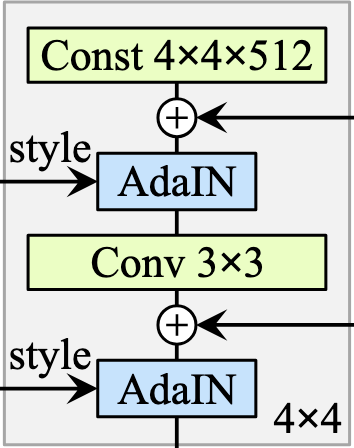

I will implement style mixing within the G model, we'll implement that right after we discuss the learned constant.

<h3>Learned Constant</h3>

In this model, we do not provide input directly to the model at the first layer. Instead our model starts from a learned constant. Essentially it will create the input itself, but once it is learned it stays the same for all inputs and at inference time it will be constant (you see what I did there...).

Why they chose to do this, I'm a unsure of but it is very interesting. Rather than providing explicit input at the first layer we essentially make the model learn where to start from 

# On a fully trained network show what the learned constant looks like?

In [43]:
class LearnedConstant(nn.Module):
    # in_c is the number of channels we start with
    def __init__(self, in_c):
        super().__init__()

        # We create a PyTorch parameter this is trainable. It has batch size 1
        # The LearnedConstant is initialised to 1 as set out in the paper.
        self.constant = nn.Parameter(torch.ones(1, in_c, 4, 4))

    # When we init the learned constant we pass in the batch size
    def forward(self, batch_size):
        # It is expanded the match the batch_size currently in network, the rest of dims stay the same
        return self.constant.expand(batch_size, -1, -1, -1)

Now we have all the tools to implement our G model. So without further ado let's get to it!

<h2>The Generator Model</h2>

We are finally here, the epitomy of the StyleGAN paper and this blog post. The G model is the key in the StyleGAN and we are about to embark on a journey to combine the pieces and make and awesome G model!!!

So here's whats gonna happen, I will split the implementation into two parts. First comes the G_ConvBlock, the building block of our G and then the G model code.

<h3>The G Conv Block</h3>

If you've read the PGGAN post, you'll recognise this following code box and also the small changes present. If you haven't read the post, once again I highly recommend you do to build the StyleGAN I think it's mandatory to implement the PGGAN too. The underlying architecture comes from the PGGAN, so to understand that is to understand the StyleGAN.

In [50]:
class G_ConvBlock(nn.Module):
    def __init__(
        self, 
        in_c, 
        out_c, 
        ksize1, 
        padding,
        ksize2=None, 
        padding2=None,
        stride=None, 
        upsample=True,
    ):
        super().__init__()
        
        layers_list = []

        # Both ksize2 and padding2 will be used even if they are not set,
        # if they are not set by parameters we just set them to ksize1 and padding
        if ksize2 is None:
            ksize2 = ksize1
        if padding2 is None:
            padding2 = padding

        # If we upsample is True, we need to ensure we upsample the image. The StyleGAN uses bilinear upsampling
        # upsample=True is the default case
        if upsample:
            layers_list.extend([
                nn.Upsample(scale_factor=2, mode='bilinear'),
                EqualLRConv2d(in_c, out_c, ksize1, padding=padding),
                NoiseLayer(out_c),
                AdaIN(256, out_c),
            ])
        # upsample=False is only set for the first layer and at the first layer we must initialise the learned constant
        # The first block only has one convolution operation
        else:
            self.learned_constant = LearnedConstant(in_c)
            layers_list.extend([
                NoiseLayer(in_c),
                AdaIN(256, in_c),
            ])

        # The following addition to layers_list is always added
        # observe that the latent_dim size to AdaIN is always 256.
        layers_list.extend([
            nn.LeakyReLU(0.2),
            EqualLRConv2d(out_c, out_c, ksize2, padding=padding2),
            NoiseLayer(out_c),
            AdaIN(256, out_c),
            nn.LeakyReLU(0.2),
        ])
        
        self.layers = nn.ModuleList(layers_list)
        # This is used to determine in the forward pass if we are at the first layer or not
        self.upsample = upsample
        
    def forward(self, w, x=None):
        # From the __init__ method, if we are the first layer we must run the forward pass of the learned_constant
        # w.size(0) is the batch_size
        if not self.upsample:
            x = self.learned_constant(w.size(0))
        
        for layer in self.layers:
            # MAY BE ABLE TO GET RID OF THIS CAUSE LEARNED CONSTANT ISNT IN SELF.LAYERS
            if isinstance(layer, LearnedConstant):
                x = layer()
            # We need to distuingush if we are at an AdaIN layer as it expects a w input. The w is provided the the G_ConvBlock call
            elif isinstance(layer, AdaIN):
                # When calling AdaIN we need to call mapping network
                x = layer(w, x)
            else:
                x = layer(x)
            
        return x

<h3>The G Model</h3>

Next comes the full G model. Once again it's similar to the PGGAN G model with some minor changes. A noticeable difference is the inclusion of style mixing, don't worry though the comments will walk you through what is going on.

In [51]:
class Generator(nn.Module):
    def __init__(self, in_c=256):
        super().__init__()

        # We initialise the MappingNetwork withing the __init__ to "link" them. The MappingNetwork must be trained and is done so
        # w.r.t to the Generator loss. To achieve updates w.r.t to the G loss they need to be linked and by calling MappingNetwork here,
        # when we update the G model the gradients will flow back to the MappingNetwork too.
        self.g_mapping = MappingNetwork()

        # We define a total of 7 G_ConvBlocks. The number of in channels and out channels follow the progressive growing regime from PGGAN
        # Once again check out my PGGAN blog for a more in depth explanation. But in short, we start with 256 channels and end with 64
        # The first layer has upsample=False so that we make the call to the learned_constant.
        self.block_4x4 = G_ConvBlock(in_c, in_c, 3, 1, upsample=False)
        self.block_8x8 = G_ConvBlock(in_c, in_c, 3, 1)
        self.block_16x16 = G_ConvBlock(in_c, in_c, 3, 1)
        self.block_32x32 = G_ConvBlock(in_c, in_c, 3, 1)
        self.block_64x64 = G_ConvBlock(in_c, in_c//2, 3, 1)
        self.block_128x128 = G_ConvBlock(in_c//2, in_c//4, 3, 1)
        self.block_256x256 = G_ConvBlock(in_c//4, in_c//4, 3, 1)

        # The output of the generator is always converted to an RGB image, an RGB image has 3 channels (red, green, blue)
        self.to_rgb_4 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_8 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_16 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_32 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_64 = EqualLRConv2d(in_c//2, 3, 1)
        self.to_rgb_128 = EqualLRConv2d(in_c//4, 3, 1)
        self.to_rgb_256 = EqualLRConv2d(in_c//4, 3, 1)

        # The output activation function ensures our outputs have value range [-1,1]
        self.tanh = nn.Tanh()

    # Notice that our forward pass is missing an "x" which is typical in PyTorch models, this is because of the learned_constant
    # and our model not having an input layer. Rather we pass in our latent vector z and also the current layer number and alpha value.
    def forward(self, z, layer_num, alpha):   
        # The first call to g_mapping
        w = self.g_mapping(z)

        # The following if statement encapsulates Style Mixing.
        # We generate a random number in between 0-1 and if it is below 0.9 we enable style mixing. 
        # the 0.9 ensures that we enable style mixing for 90% of all batches.
        # Mixing is applied to 90% of the batches, from Table 2 in the StyleGAN paper
        if torch.rand(1).item() < 0.9:
            # We sample a second latent vector, randn_like ensures the dims match the first latent vector
            z2 = torch.randn_like(z)
            # Generate a second intermediate latent space
            w2 = self.g_mapping(z2)

            # Need to choose a random crossover point
            crossover_point = random.randint(1, layer_num)
        else:
            crossover_point = None
        
        # First check if style mixing is active for the current forward pass, this is done by checking if crossover_point is something other than None
        # if it is None the first part of the if statement is False
        # Then if style mixing is active we need to ensure we've reached the crossover point
        if crossover_point and crossover_point >= 1:
            w = w2
        out_4 = self.block_4x4(w)  # First block has no input x
        if layer_num == 1:
            out = self.to_rgb_4(out_4)
            out = self.tanh(out)
            return out

        if crossover_point and crossover_point >= 2:
            w = w2
        out_8 = self.block_8x8(w, out_4)
        if layer_num == 2:
            skip = self.to_rgb_4(out_4)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_8(out_8)
            
            out = ((1-alpha) * skip) + (alpha * out)
            out = self.tanh(out)
            return out

        if crossover_point and crossover_point >= 3:
            w = w2
        out_16 = self.block_16x16(w, out_8)
        if layer_num == 3:
            skip = self.to_rgb_8(out_8)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_16(out_16)
            
            out = ((1-alpha) * skip) + (alpha * out)
            out = self.tanh(out)
            return out

        if crossover_point and crossover_point >= 4:
            w = w2
        out_32 = self.block_32x32(w, out_16)
        if layer_num == 4:
            skip = self.to_rgb_16(out_16)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_32(out_32)
            
            out = ((1-alpha) * skip) + (alpha * out)
            out = self.tanh(out)
            return out

        if crossover_point and crossover_point >= 5:
            w = w2
        out_64 = self.block_64x64(w, out_32)
        if layer_num == 5:
            skip = self.to_rgb_32(out_32)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_64(out_64)
            
            out = ((1-alpha) * skip) + (alpha * out)
            out = self.tanh(out)
            return out

        if crossover_point and crossover_point >= 6:
            w = w2
        out_128 = self.block_128x128(w, out_64)
        if layer_num == 6:
            skip = self.to_rgb_64(out_64)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_128(out_128)
            
            out = ((1-alpha) * skip) + (alpha * out)
            out = self.tanh(out)
            return out

        if crossover_point and crossover_point >= 7:
            w = w2
        out_256 = self.block_256x256(w, out_128)
        if layer_num == 7:
            skip = self.to_rgb_128(out_128)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_256(out_256)
            
            out = ((1-alpha) * skip) + (alpha * out)
            out = self.tanh(out)
            return out

g = Generator().to(device)

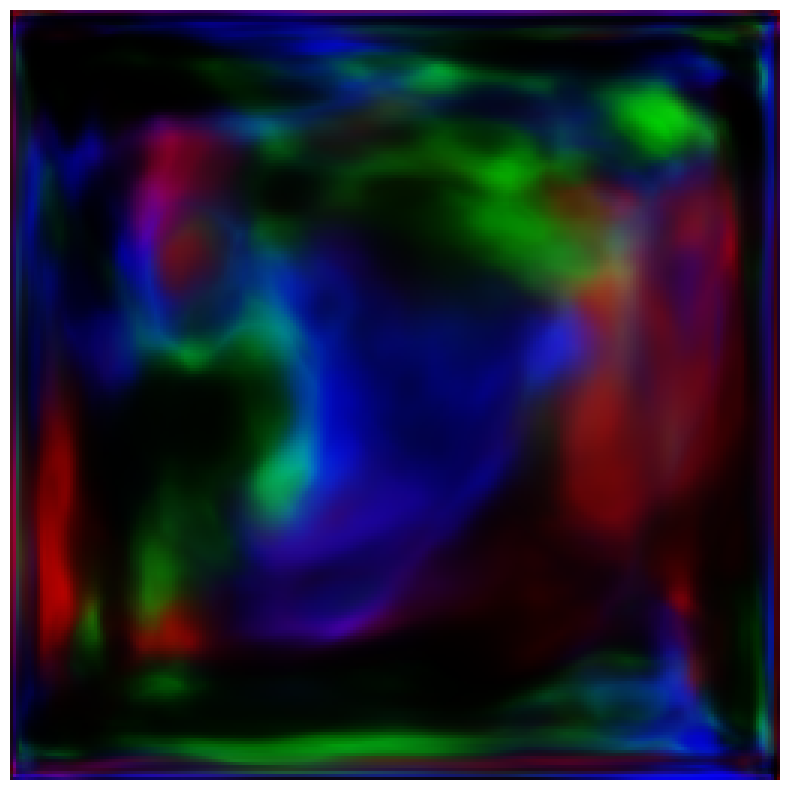

(None, torch.Size([1, 3, 256, 256]))

In [58]:
# TESTING G
g_in = torch.randn(1, 256, device=device)
g_out = g(g_in, alpha=0.5, layer_num=7)
show_images(g_out), g_out.shape

There we have it the StyleGAN G model, now let's train it!

<h3>Preparing to Train the StyleGAN<h3>

There a few things we should cover before we implement the training loop. Once again a lot of the details follow the PGGAN training setup but with a few changes, also I don't follow the paper to the T here and I advise you not to either. They had trained on 8 V100 GPUs for a week, I have a single 3090 and for whatever card you have you may need to adapt the training scheme to make it run in a reasonable time and run with regards to your memory constraints.

Firstly, let's implement the helper functions we use throughout the training loop. We have a get_dataloader, which will return a dataloader with different batch sizes (more to come). get_batch_size which is used in conjunction with the dataloader, we make use of different batch sizes based on the resolution[<sup>8</sup>](#8). Next we have get_total_iters, we also train each layer for a different number of iterations this comes from the fact that the lower resolution layers converge quicker and as such we can save time by training them for less time. The different iteration training based on resolution was something I added, it saves us time and energy usage (a.k.a I have to spend less on my electricity bill). We also have get_params_with_lr, in the paper it is stated that the mapping network has a LR which is reduced by two orders of magnitude compared to the lr of the rest of the network. Given that we init the mapping network in G the mapping network params are in the G network and can be accessed based on their naming convention.

I include the code and comments for all these utilities in one code block below.

In [64]:
def get_dataloader(image_size, batch_size=8):
    # Just some basic transforms, image_size holds the resolution of the current layer
    # so we create a new dataloader after stabilising each layer
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize images to the required size
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # I assume your CelebA HQ 256 directory is in the same one as this notebook, feel free to change it
    dataset = ImageFolder(root='./celeba_hq_256', transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

    return dataloader

# Simple mapping function, it doesn't really need to be a function but encapsulating it in one makes it 
# clear to see what is happening. The batch sizes I pick are determined by me, 
# feel free to experiment and change them
def get_batch_size(resolution):
    batch_sizes = {
        4: 256,
        8: 256,
        16: 128,
        32: 128,
        64: 128,
        128: 64,
        256: 32,
    }
    return batch_sizes.get(resolution) 

# Similar story here as for get_batch_size
def get_total_iters(resolution):
    total_iters = {
        4: 50000,
        8: 70000,
        16: 70000,
        32: 70000,
        64: 80000,
        128: 90000,
        256: 100000,
    }
    return total_iters.get(resolution)

# To get the params for the mapping network we look for parameters with "mapping" in the name
def get_params_with_lr(model):
    mapping_params = []
    other_params = []
    for name, param in model.named_parameters():
        if 'mapping' in name:  # Adjust this condition based on your actual naming convention
            mapping_params.append(param)
        else:
            other_params.append(param)
    return mapping_params, other_params
# To illustrate how this works look at this
for name, param in g.named_parameters():
    print(name)
# The naming convetion of PyTorch has the module name at the start. This is what we take advantage of

g_mapping.layers.0.linear.bias
g_mapping.layers.0.linear.weight_orig
g_mapping.layers.2.linear.bias
g_mapping.layers.2.linear.weight_orig
g_mapping.layers.4.linear.bias
g_mapping.layers.4.linear.weight_orig
g_mapping.layers.6.linear.bias
g_mapping.layers.6.linear.weight_orig
g_mapping.layers.8.linear.bias
g_mapping.layers.8.linear.weight_orig
g_mapping.layers.10.linear.bias
g_mapping.layers.10.linear.weight_orig
g_mapping.layers.12.linear.bias
g_mapping.layers.12.linear.weight_orig
g_mapping.layers.14.linear.bias
g_mapping.layers.14.linear.weight_orig
block_4x4.learned_constant.constant
block_4x4.layers.0.weight
block_4x4.layers.1.map_layer.linear.bias
block_4x4.layers.1.map_layer.linear.weight_orig
block_4x4.layers.3.conv.bias
block_4x4.layers.3.conv.weight_orig
block_4x4.layers.4.weight
block_4x4.layers.5.map_layer.linear.bias
block_4x4.layers.5.map_layer.linear.weight_orig
block_8x8.layers.1.conv.bias
block_8x8.layers.1.conv.weight_orig
block_8x8.layers.2.weight
block_8x8.layers.3.m

<h4>Frechet-Inception Distance - FID</h4>

Metrics are important, they help us reason about our work objectively. In the PGGAN post, to assess the quality of our images we simply looked at the photos and used our intuition, this isn't a good practice as we have biases and are usually not the best judges of quality. Think about what good generated images would look like and how would we assess it? We want our generated images to have variation (no mode collapse please), they should be high resolution and they should follow how the real images look (i.e. they should look real). These aspects are hard to formalise, but it can be achieved by the Frechet-Inception Distance.

In the StyleGAN paper, the authors use Frechet-Inception Distance (FID)[<sup>9</sup>(#9)] as the metric to assess image quality. FID is quite cool, it's goal is to compare the distribution of the generated images against the distribution of the real (ground truth) images. It does so using the Inception V3 image classification model, which is pretrained on the ImageNet dataset, namely we pass the real images and the generated images through the network and compute the mean and std-dev of the last layer prior to output of the Inception V3 model. The two sets of statistics are then compared against each other and we get an FID score, the lower the score the better. It can detect mode collapse as a result of the std-dev comparison, if mode collapses std-dev will be very low and not close to real images std-dev.

FID does have some disadvantages, firstly the score is affected by the number of samples passed through. 10000 real and fake images is usually a good starting point, however I just use all real images from the CelebA dataset which is 30000 images. I then also generated 30000 fake images and pass them to the FID function. 

Let's implement the helper function to calculate FID for our G model.

# Study FID more and put better explainer here

In [1]:
# Now sample 30k fake and add them to fid
def resize(images):
    # Resize to 299x299, the inception v3 model expects 299,299 images so we just resize our images to
    # this size
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
    ])
    return transform(images)

# We make use of the FID class provided by the torchmetrics library provided by PyTorch Lightning
# This class works by "adding" fake and real images to the model
# So I create two functions, one for adding fake images and one for real images
def add_fake_images(g_running, num_images, batch_size, latent_dim, device, layer_num, alpha=1):
    # The function takes in g_running and all params needed to generate images
    # we use g_running in this function as it is the model we use to output our fake images
    g_running.eval()
    
    # Set torch.no_grad to turn off gradients, it makes the code run faster and use less memory as gradients
    # aren't tracked
    with torch.no_grad():
        # Generate 30000 images to pass to the FID model, we pass them as we generate them to save
        # images
        for _ in tqdm(range(0, num_images, batch_size), desc="Generating images"):
            z = torch.randn(batch_size, latent_dim, device=device)
            batch_images = g_running(z, layer_num=layer_num, alpha=alpha)
        
            # resize images
            resize_batch = resize(batch_images)
            # Inception v3 requires pixel ranges to be [0,255] currently it's [-1,1], 
            # this line handles the conversion
            resize_batch = ((resize_batch + 1) * 127.5).clamp(0, 255)
            # Inception v3 also expects input data type to be uint8, this can be handled with a simple cast
            resize_batch = resize_batch.to(torch.uint8)
            
            # Update FID
            fid.update(resize_batch, real=False)
            
            # Clear GPU cache, to save memory
            torch.cuda.empty_cache()

# The second function just takes in the data_loader as a parm
def add_real_imgs(data_loader):
    # we pass all batches to the FID model i.e. 30k images
    for batch in tqdm(data_loader, desc="Processing real images"):
        imgs, _ = batch
        # Resize, convert to [0,255] range and cast to uint8 as before
        imgs = resize(imgs)
        imgs = imgs.to(device)
        imgs = ((imgs + 1) * 127.5).clamp(0, 255)
        imgs = imgs.to(torch.uint8)
        fid.update(imgs, real=True)

# Final function which combines both of the image adding functions
def calculate_and_save_fid(layer_num, iteration, data_loader, g_running, num_fake_images, batch_size, latent_dim, device, fid_file, alpha=1):
    # We reset the FID score statistics for recalculation
    fid.reset()
    # Add the real and fake images
    add_fake_images(g_running, num_fake_images, batch_size, latent_dim, device, layer_num, alpha=alpha)
    add_real_imgs(data_loader)
    # Compute FID score and output it
    fid_score = fid.compute()
    print(f"FID score for layer {layer_num}, iteration {iteration}: {fid_score.item()}")
    
    # We also save the scores to a file
    with open(fid_file, 'a') as f:
        f.write(f"Layer {layer_num}, Iteration {iteration}: {fid_score.item()}\n")

So there we have all the helper functions we will be using to train our StyleGAN. 

<h3>Training the StyleGAN</h3>

Quickly, before we set off if you have read the Goodfellow GAN or PGGAN blog this part of the blog will look a little different. I made some discoveries while training this model, firstly Jupyter notebooks are not a good medium (in my experience at least) for large training runs. My kernel died more times than I would like while training the StyleGAN often costing hours of progress, energy and time, even with the checkpoints. I love notebooks, but I think for this sort of stuff they are not optimised and going forwards I think I will stick with them for prototyping (the feedback from a notebook is amazing) and then make use of actual python files for the training loops (or any other long running code). To this end, I will provide a link to the python files for training (check out the sidebar on the right) and the output's here will look different as I have to load the images from disk rather than them being outputted straight to the notebook as before.

Now that that's out of the way, let's take a look at the training loop! (Given the use of .py file for training the loop in that file may look slightly different, but is functionally the same)

<h4>The Training Loop - We're almost there!</h4>

So we're here, the culmination of all our struggles now it's time to see what they get us. Let's get an overview of the training loop, refer to code comments for further details. Firstly, we generate our checkpoint and sample directories, I also create an "fid.txt" file to keep track of FID scores). Next, we intialise our D, G, G_running and fid models. Setup our optimisers, accounting for the learning rate adjusment required for the mapping network. Then there's some boring stuff and then we start training. The training scheme is the same as the first post, two for loops one for introducing the network and the second for stabilisation. This training loop may take a while to run, in the paper the authors stated the FID kept decreasing when using this model compared to PGGAN so to get it to converge we need to have a longer training loop.

In [ ]:
# Create new checkpoint dir with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join('./checkpoints', f'run_{timestamp}')
checkpoint_dir = os.path.join(run_dir, f"checkpoint_{timestamp}")
sample_dir = os.path.join(run_dir, f"sample_{timestamp}")
# Create a file to log FID scores
fid_file = os.path.join(run_dir, 'fid.txt')

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

# Init models
g = Generator().to(device)
d = Discriminator().to(device)
g_running = Generator().to(device)

# Remove gradients from g_running as they're not needed
g_running.train(False)

# Init FID model, feature=2048 means which layer to use for FID calculation. The number represents the number of
# features, 2048 corresponds to the last layer prior to output as we discussed. You can use layers before this one.
# such as 64, 192, 768 but I found these report lower FID I guess it's because they aren't as good. Correct me on that
# if I'm wrong
fid = FrechetInceptionDistance(feature=2048).to(device)

# Get all the params of G model, specifically we care about the mapping_params.
mapping_params, other_params = get_params_with_lr(g)

# learning rate is set to 0.001 for all network except mapping network which is set to 0.001 * 0.01
# The optimisers are the same as in PGGAN in all regards except mapping network (which wasn't in PGGAN at all
# anyways)
lr = 0.001 # Try 0.003? Or reduce LR as progreesing. 0.005 for layers 1-3 then 0.003
g_optimizer = torch.optim.Adam([
    {'params': mapping_params, 'lr': lr * 0.01},  # 0.01 * LR for mapping network
    {'params': other_params, 'lr': lr}  # Regular LR for other parts
], betas=(0.0, 0.99))
d_optimizer = torch.optim.Adam(d.parameters(), lr=lr, betas=(0.0, 0.99))

# The following stuff is for checkpoint. These are very handy as training can fail and it saves us alot
# time to just run from checkpoint instead of the whole thing again.
start_layer = 1
start_iter = 0
# Check if resuming from a checkpoint
resume_checkpoint = False
# resume_checkpoint = If you have a checkpoint replace this with the path of checkpoint file
if resume_checkpoint:
    if os.path.isfile(resume_checkpoint):
        # If checkpoint exists we load everything needed to resume training
        # Note we save checkpoints only after completely stabilising a layer
        print(f"=> loading checkpoint '{resume_checkpoint}'")
        checkpoint = torch.load(resume_checkpoint, weights_only=False)
        start_layer = checkpoint['layer_num'] + 1
        start_iter = checkpoint['iteration'] + 1
        g.load_state_dict(checkpoint['g_state_dict'])
        d.load_state_dict(checkpoint['d_state_dict'])
        g_running.load_state_dict(checkpoint['g_running_state_dict'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])

        print(f"=> loaded checkpoint '{resume_checkpoint}' (layer {start_layer}, iteration {start_iter})")
    else:
        print(f"=> no checkpoint found at '{resume_checkpoint}'")
else:
    print("Starting training from the beginning")

# Init EMA 
EMA(g_running, g, 0)

# List of image sizes
img_size = [4, 8, 16, 32, 64, 128, 256]

# We evaluate FID every 5k iterations
num_iters_for_eval = 5000

# We want to gen 30k fake images for FID calculation to match 30k real images
num_fake_images = 30000
latent_dim = 256  # Adjust based on your model's input size

# Start_layer to 8 we start by introducing the current resolution layer
for layer_num in range(start_layer, 8):
    alpha = 0

    # Get current resolution
    resolution = img_size[layer_num-1]
    # Get batch size, total iters for current layer and the data loader for this layer
    batch_size = get_batch_size(resolution)
    total_iters = get_total_iters(resolution)
    data_loader = get_dataloader(resolution, batch_size)
    dataset = iter(data_loader)

    # Init a progress bar
    print(f'Training resolution: {resolution}x{resolution}, Batch size: {batch_size}')
    pbar = tqdm(range(total_iters))

    # Begin introducing layer phase
    for i in pbar:
        d.zero_grad()
        
        try:
            real_imgs, label = next(dataset)
        except (OSError, StopIteration):
            # If we reach the end of the dataset, we reintialise the iterable
            # basically starting again
            dataset = iter(data_loader)
            real_imgs, label = next(dataset)

        # Train D
        real_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        label = label.to(device)
        real_preds = d(real_imgs, layer_num=layer_num, alpha=alpha)
        # The line below implements a small weight penalty
        # It ensures the D loss isnt too far away from 0 preventing extreme outputs 
        real_preds = real_preds.mean() - 0.001 * (real_preds**2).mean()

        # sample input for G
        z = torch.randn(real_size, 256, device=device)

        gen_imgs = g(z, layer_num=layer_num, alpha=alpha)

        gen_preds = d(gen_imgs.detach(), layer_num=layer_num, alpha=alpha)
        gen_preds = gen_preds.mean() 

        # Gradient Penalty - GP
        eps = torch.rand((real_size, 1, 1, 1)).to(device)
        x_hat = (eps * real_imgs) + ((1-eps) * gen_imgs.detach())
        x_hat.requires_grad_(True)
        pred_x_hat = d(x_hat, layer_num=layer_num, alpha=alpha)

        WGAN = gen_preds.mean() - real_preds.mean()
        grads = torch.autograd.grad(
            outputs=pred_x_hat, inputs=x_hat,
            grad_outputs=torch.ones_like(pred_x_hat),
            create_graph=True, retain_graph=True
        )[0]
        GP = ((grads.norm(2, dim=1) - 1) ** 2).mean() 

        d_loss = WGAN + 10 * GP
        d_loss.backward()
        d_optimizer.step()

        # Now lets train the Generator
        g.zero_grad()
        z = torch.randn(real_size, 256, device=device)
        gen_imgs = g(z, layer_num=layer_num, alpha=alpha)
        gen_preds = d(gen_imgs, layer_num=layer_num, alpha=alpha)
        g_loss = -gen_preds.mean()
        g_loss.backward()
        g_optimizer.step()

        EMA(g_running, g)

        inc = (1-alpha) / (len(pbar)-i)
        alpha += inc   

        if i % num_iters_for_eval == 0:
            sample_z = torch.randn(16, 256, device=device)
            sample_imgs_EMA = g_running(sample_z, layer_num=layer_num, alpha=alpha)
            save_image(sample_imgs_EMA, f'{sample_dir}/sample_intro_layer_{layer_num}_iter_{i}.png', nrow=4, normalize=True)
            print(f'Introducing - G_running images images after iter: {i} | alpha: {alpha}')
            show_images(sample_imgs_EMA)

            calculate_and_save_fid(layer_num, i, data_loader, g_running, num_fake_images, batch_size, latent_dim, device, fid_file, alpha=alpha)

    with torch.no_grad():
        sample_z = torch.randn(16, 256, device=device)
        sample_imgs = g(sample_z, layer_num=layer_num, alpha=alpha)
        sample_imgs_EMA = g_running(sample_z, layer_num=layer_num, alpha=alpha)
        print(f'Images after introducing layer: {layer_num} | alpha: {alpha}')
        print('G images')
        show_images(sample_imgs)
        print('G_running images')
        show_images(sample_imgs_EMA)

        calculate_and_save_fid(layer_num, 'final intro', data_loader, g_running, num_fake_images, batch_size, latent_dim, device, fid_file, alpha=alpha)

    stabilise_pbar = tqdm(range(total_iters))
    for i in stabilise_pbar:
        d.zero_grad()

        try:
            real_imgs, label = next(dataset)
        except (OSError, StopIteration):
            dataset = iter(data_loader)
            real_imgs, label = next(dataset)

        # Train D
        real_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        label = label.to(device)
        real_preds = d(real_imgs, layer_num=layer_num, alpha=alpha)
        real_preds = real_preds.mean() - 0.001 * (real_preds**2).mean()

        # sample input for G
        z = torch.randn(real_size, 256, device=device)

        gen_imgs = g(z, layer_num=layer_num, alpha=alpha)

        gen_preds = d(gen_imgs.detach(), layer_num=layer_num, alpha=alpha)
        gen_preds = gen_preds.mean()

        # Gradient Penalty - GP
        eps = torch.rand((real_size, 1, 1, 1)).to(device)
        x_hat = (eps * real_imgs) + ((1-eps) * gen_imgs.detach())
        x_hat.requires_grad_(True)
        pred_x_hat = d(x_hat, layer_num=layer_num, alpha=alpha)

        WGAN = gen_preds.mean() - real_preds.mean()
        grads = torch.autograd.grad(
            outputs=pred_x_hat, inputs=x_hat,
            grad_outputs=torch.ones_like(pred_x_hat),
            create_graph=True, retain_graph=True
        )[0]
        GP = ((grads.norm(2, dim=1) - 1) ** 2).mean() 

        # WGAN_GP_loss = d_loss
        d_loss = WGAN + 10 * GP
        d_loss.backward()
        d_optimizer.step()

        # Now lets train the Generator
        g.zero_grad()
        z = torch.randn(real_size, 256, device=device)
        gen_imgs = g(z, layer_num=layer_num, alpha=alpha)
        gen_preds = d(gen_imgs, layer_num=layer_num, alpha=alpha)
        g_loss = -gen_preds.mean()
        g_loss.backward()
        g_optimizer.step()

        EMA(g_running, g)

        if i % num_iters_for_eval == 0:
            sample_z = torch.randn(16, 256, device=device)
            sample_imgs_EMA = g_running(sample_z, layer_num=layer_num, alpha=alpha)
            save_image(sample_imgs_EMA, f'{sample_dir}/sample_stabilising_layer_{layer_num}_iter_{i}.png', nrow=4, normalize=True)
            print(f'Stabilising - G_running images images after iter: {i} | alpha: {alpha}')
            show_images(sample_imgs_EMA)
            calculate_and_save_fid(layer_num, i, data_loader, g_running, num_fake_images, batch_size, latent_dim, device, fid_file, alpha=alpha)

    with torch.no_grad():
        sample_z = torch.randn(16, 256, device=device)
        sample_imgs = g(sample_z, layer_num=layer_num, alpha=alpha)
        sample_imgs_EMA = g_running(sample_z, layer_num=layer_num, alpha=alpha)
        save_image(sample_imgs_EMA, f'{sample_dir}/sample_layer_{layer_num}_completed.png', nrow=4, normalize=True)
        print(f'Images after stabilising layer: {layer_num} | alpha: {alpha}')
        print('G images')
        show_images(sample_imgs)
        print('G_running images')
        show_images(sample_imgs_EMA)

        calculate_and_save_fid(layer_num, 'final_stable', data_loader, g_running, num_fake_images, batch_size, latent_dim, device, fid_file, alpha=alpha)

    torch.save({
        'g_state_dict': g.state_dict(),
        'g_running_state_dict': g_running.state_dict(),
        'd_state_dict': d.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict(),
        'layer_num': layer_num,
        'iteration': i
    }, f'{checkpoint_dir}/completed_checkpoint_g_and_EMA_layer_{layer_num}.pth')

# ADD IMAGES AND EXPOSITION ON THEM HERE
# ADD COMPARISON TO PGGAN IMAGES TRAINED FOR SIMILAR ITERS

---
<a id="1" style="text-decoration: none; color: inherit;"><sup>1</sup></a> <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf">https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf</a>

<a id="2" style="text-decoration: none; color: inherit;"><sup>2</sup></a> A linear subspace means some spaces of the vector $\textbf{w}$ and the factors of variation are the different aspects of a face. E.g. hair colour, skin colour, nose shape, nose position, eyelid shape placement of ears etc (this is not concrete it is just an explanation). So what does it mean, I take it as different areas of the vector control different areas of the generated images, for example dimensions 1-24 of $\textbf{w}$ could correspond to face placement i.e. subsets of the vector directly control different aspects of the images generation. If I am wrong here please let me know @ <a href='m&#97;&#105;&#108;&#116;o&#58;y%7&#53;s&#117;&#102;&#109;oh&#97;mm&#97;%&#54;4&#64;l%&#54;9ve&#46;&#99;&#111;m'>y&#117;&#115;u&#102;mo&#104;&#97;m&#109;ad&#64;l&#105;ve&#46;co&#109;</a>

<a id="3" style="text-decoration: none; color: inherit;"><sup>3</sup></a> <a href="https://arxiv.org/pdf/1703.06868">https://arxiv.org/pdf/1703.06868</a>

<a id="4" style="text-decoration: none; color: inherit;"><sup>4</sup></a> Bear with me here, this is quite confusing at first but I will explain it as we go along.

<a id="5" style="text-decoration: none; color: inherit;"><sup>5</sup></a> <a href="https://arxiv.org/pdf/1703.06868">https://arxiv.org/pdf/1703.06868</a>

<a id="6" style="text-decoration: none; color: inherit;"><sup>6</sup></a> A "latent vector" just means a hidden vector. I.e. something which we cannot modify or observe. A latent vector acts as a lower dimensional code (lower dimensional compared to the output), which the GAN can use to encode into an image. This is what the GAN is learning to do.

<a id="7" style="text-decoration: none; color: inherit;"><sup>7</sup></a> Regularisation is a mathematical technique to make model "simpler". I think it follows the principle of parsimony where simpler things are preferred as they are more likely to be true. It also prevents overfitting.

<a id="8" style="text-decoration: none; color: inherit;"><sup>8</sup></a> When using this function you may need to reduce the batch sizes based on the memory of your GPU. When running the training loop if you face a memory error of max capacity used then reduce the batch sizes by a half and continue to do so until it works.

<a id="9" style="text-decoration: none; color: inherit;"><sup>9</sup></a> The paper which introduced the FID score is <a href="https://arxiv.org/pdf/1706.08500">https://arxiv.org/pdf/1706.08500</a>. Note that FID is still the standard metric used to assess generated image quality, showing it's importance and usefulness.